In [1]:
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt

sns.set_theme(style="ticks", palette="muted")
sns.set_context("notebook", font_scale=1.5)

plt.rcParams.update({
#    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
#    "text.usetex": True,
    "pgf.rcfonts": False,
})

def find_csv_files(base_directory, prefix, ignore=None):
    csv_files = []
    for root, dirs, files in os.walk(base_directory):
        for file in files:
            if file.startswith(prefix) and file.endswith('.csv'):
                if ignore is not None and ignore in file:
                    continue
                csv_files.append(os.path.join(root, file))
    return csv_files

def load_csv_files(csv_files):
    dataframes = []
    for file in csv_files:
        df = pd.read_csv(file)
        dataframes.append(df)
    return dataframes

def concatenate_dataframes(dataframes):
    combined_df = pd.concat(dataframes, ignore_index=True)
    return combined_df


base_directory = 'results'
prefix = 'st_benchmark'
csv_files = find_csv_files(base_directory, prefix)
dataframes = load_csv_files(csv_files)
df = concatenate_dataframes(dataframes)
df['max_time'] = pd.to_numeric(df['max_time'], errors='coerce')
df['max_time'] = df['max_time'].fillna(0)
df['max_time'] = df['max_time'].astype('Int64')

df['method_type'] = df.apply(lambda row: f"{row['method']} (max. {row['max_time']}s)" 
                                  if pd.notna(row['max_time']) and row['max_time'] != 0 
                                  else row['method'], axis=1)

df

,seed,n_terminals,graph_nodes,graph_edges,is_scale_free,scale_free_params,total_weight,max_time,tolerance,strict_acyclic,integrality_focus,method,nodes_steiner,edges_steiner,cost_of_steiner_tree,cost_diff,time,time_diff,method_type
0,0,10,1000,2991,False,"5,0.1",1489.334147,0,0.00100,NaN,NaN,nx,38,37,6.336373,0.601080,0.030361,-745.059340,nx
1,0,10,1000,2991,False,"5,0.1",1489.334147,7200,0.00100,1.0,1.0,corneto,38,37,5.735294,-0.601080,745.089700,745.059340,corneto (max. 7200s)
2,0,30,500,1000,True,"5,0.1",516.906338,0,0.00001,NaN,NaN,nx,90,89,36.800003,6.447920,0.028346,-716.463409,nx
3,0,30,500,1000,True,"5,0.1",516.906338,7200,0.00001,1.0,1.0,corneto,99,98,30.352084,-6.447920,716.491755,716.463409,corneto (max. 7200s)
4,0,30,1250,2496,False,"5,0.1",1242.463823,0,0.00001,NaN,NaN,nx,66,65,20.312937,1.456576,0.037676,-399.468077,nx
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1779,0,50,500,996,False,"5,0.1",515.900094,600,0.00100,1.0,1.0,corneto,99,98,22.420924,-5.399933,309.922972,309.883051,corneto (max. 600s)
1780,0,50,1500,3000,True,"5,0.1",1492.875319,0,0.00100,NaN,NaN,nx,221,220,78.314391,19.577491,0.040992,-853.757577,nx
1781,0,50,1500,3000,True,"5,0.1",1492.875319,7200,0.00100,1.0,1.0,corneto,221,220,58.736900,-19.577491,853.798569,853.757577,corneto (max. 7200s)
1782,0,10,1000,2000,True,"5,0.1",997.828291,0,0.00100,NaN,NaN,nx,62,61,19.412427,1.663111,0.035800,-7201.086583,nx


In [2]:
df_cn = df[df.method=="corneto"].copy()
df_cn["cost_of_nx"] = df_cn["cost_of_steiner_tree"] + df_cn["cost_diff"].abs()
df_cn["improvement"] = ((df_cn["cost_of_nx"] - df_cn["cost_of_steiner_tree"])/df_cn["cost_of_nx"])*100

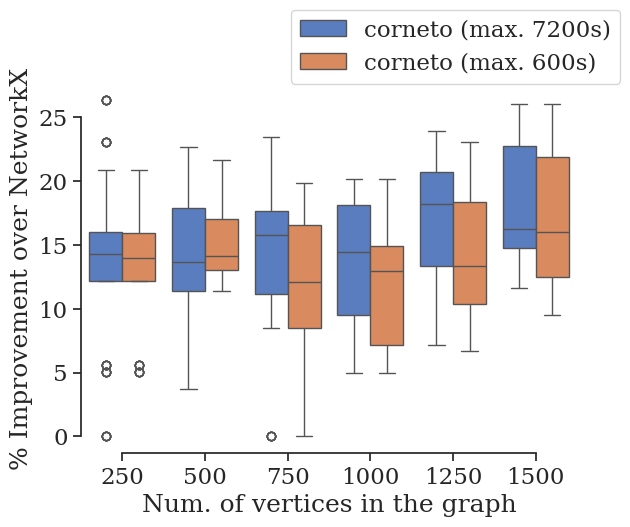

In [3]:
sns.boxplot(data=df_cn, x="graph_nodes", y="improvement", hue="method_type", fill=True, log_scale=False)
sns.despine(trim=True, left=False)
plt.legend(loc='center left', bbox_to_anchor=(0.40, 1.10))
plt.xlabel("Num. of vertices in the graph")
plt.ylabel("% Improvement over NetworkX")
plt.savefig("steiner_cn_nx_improv_vertices.pdf", format="pdf")

In [4]:
df_cn[(df_cn.max_time==600) & (df_cn.strict_acyclic == 1.0)].improvement.mean()

13.467206424510444

In [5]:
df_cn[(df_cn.max_time==7200) & (df_cn.strict_acyclic == 1.0)].improvement.mean()

15.357961627261664

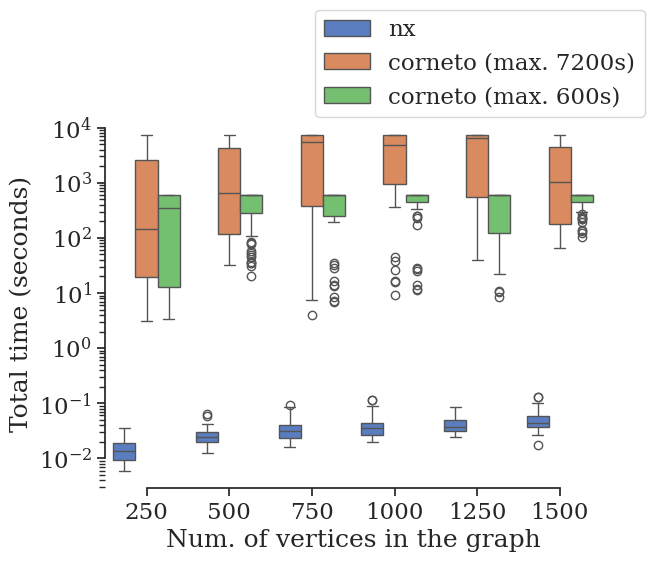

In [6]:
sns.boxplot(data=df, x="graph_nodes", y="time", hue="method_type", log_scale=True)
sns.despine(trim=True, left=False)
plt.legend(loc='center left', bbox_to_anchor=(0.40, 1.15))
plt.xlabel("Num. of vertices in the graph")
plt.ylabel(f"Total time (seconds)")
plt.savefig("time.pdf", format="pdf")

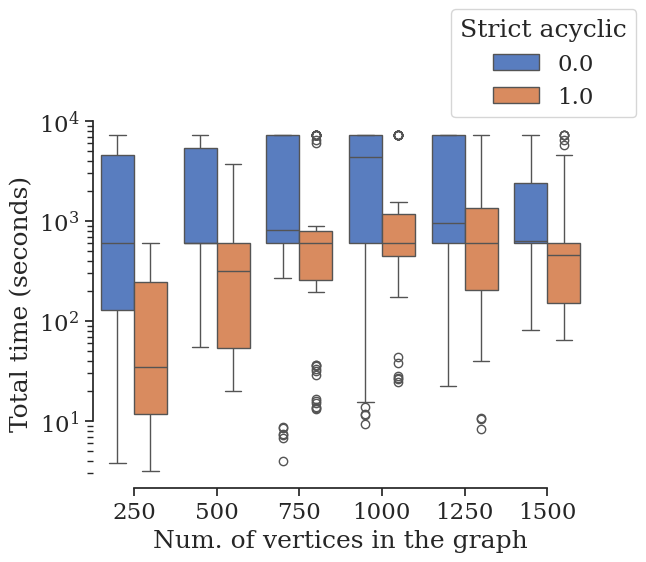

In [7]:
sns.boxplot(data=df_cn, x="graph_nodes", y="time", hue="strict_acyclic", log_scale=True)
sns.despine(trim=True, left=False)
plt.legend(loc='center left', bbox_to_anchor=(0.70, 1.15), title="Strict acyclic")
plt.xlabel("Num. of vertices in the graph")
plt.ylabel(f"Total time (seconds)")
plt.savefig("strict_acyclic.pdf", format="pdf")

In [8]:
csv_files = find_csv_files(base_directory, prefix, ignore="mt7200")
dataframes = load_csv_files(csv_files)
df = concatenate_dataframes(dataframes)
df = df[(df.strict_acyclic.isna()) | (df.strict_acyclic > 0)]
df

,seed,n_terminals,graph_nodes,graph_edges,is_scale_free,scale_free_params,total_weight,max_time,tolerance,strict_acyclic,integrality_focus,method,nodes_steiner,edges_steiner,cost_of_steiner_tree,cost_diff,time,time_diff
0,0,10,1000,1996,False,"5,0.1",995.893973,NaN,0.00010,NaN,NaN,nx,26,25,6.190261,0.418923,0.021841,-24.853154
1,0,10,1000,1996,False,"5,0.1",995.893973,600.0,0.00010,1.0,1.0,corneto,27,26,5.771338,-0.418923,24.874994,24.853154
2,0,50,1000,1996,False,"5,0.1",995.893973,NaN,0.00010,NaN,NaN,nx,103,102,29.487310,3.914833,0.037522,-600.587218
4,0,40,250,496,False,"5,0.1",262.557405,NaN,0.00010,NaN,NaN,nx,66,65,26.208063,4.201310,0.017194,-14.521033
5,0,40,250,496,False,"5,0.1",262.557405,600.0,0.00010,1.0,1.0,corneto,70,69,22.006752,-4.201310,14.538228,14.521033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
714,0,10,1500,3000,True,"5,0.1",1492.875319,NaN,0.00001,NaN,NaN,nx,59,58,20.798654,1.970681,0.034382,-601.939116
715,0,10,1500,3000,True,"5,0.1",1492.875319,600.0,0.00001,1.0,1.0,corneto,58,57,18.827972,-1.970681,601.973498,601.939116
716,0,10,1250,2496,False,"5,0.1",1242.463823,NaN,0.00010,NaN,NaN,nx,30,29,10.569072,2.182266,0.038241,-25.114471
718,0,50,500,996,False,"5,0.1",515.900094,NaN,0.00100,NaN,NaN,nx,90,89,27.820857,5.399933,0.039920,-309.883051


In [9]:
max_time = df.max_time.dropna().unique()[0].astype(int)
max_time # seconds

600

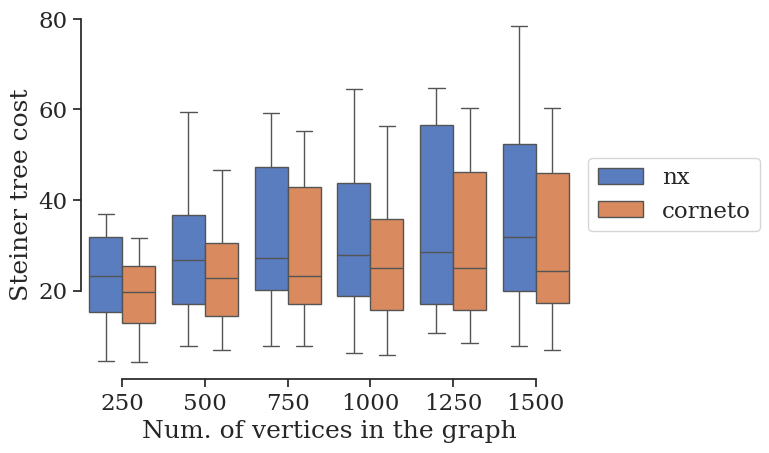

In [10]:
sns.boxplot(data=df, x="graph_nodes", y="cost_of_steiner_tree", hue="method", fill=True, log_scale=False)
sns.despine(trim=True, left=False)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Num. of vertices in the graph")
plt.ylabel("Steiner tree cost")
plt.savefig("steiner_cn_nx_vertices_600s.pdf", format="pdf")

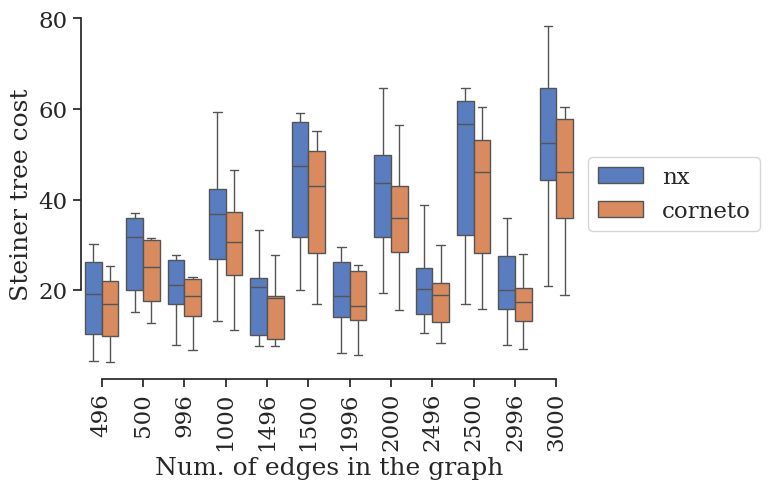

In [11]:
sns.boxplot(data=df, x="graph_edges", y="cost_of_steiner_tree", hue="method", fill=True, log_scale=False)
sns.despine(trim=True, left=False)
plt.xticks(rotation=90)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Num. of edges in the graph")
plt.ylabel("Steiner tree cost")
plt.savefig("steiner_cn_nx_edges_600s.pdf", format="pdf")

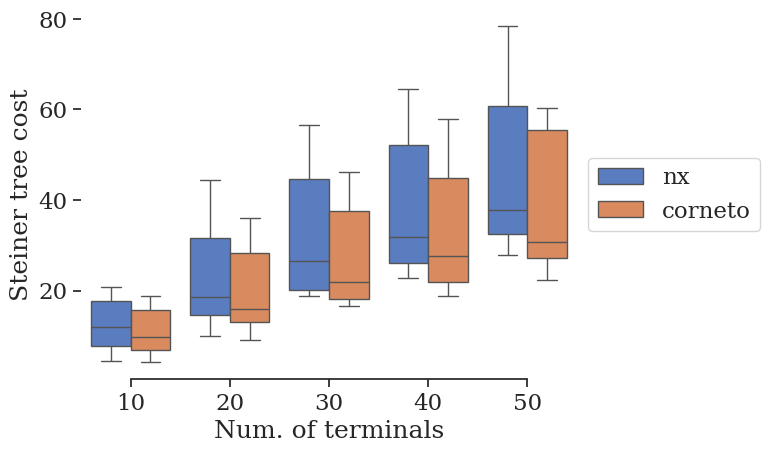

In [12]:
sns.boxplot(data=df, x="n_terminals", y="cost_of_steiner_tree", hue="method", log_scale=False)
sns.despine(trim=True, left=True)
#plt.xticks(rotation=90)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Num. of terminals")
plt.ylabel("Steiner tree cost")
plt.savefig("steiner_cn_nx_terminals_600s.pdf", format="pdf")

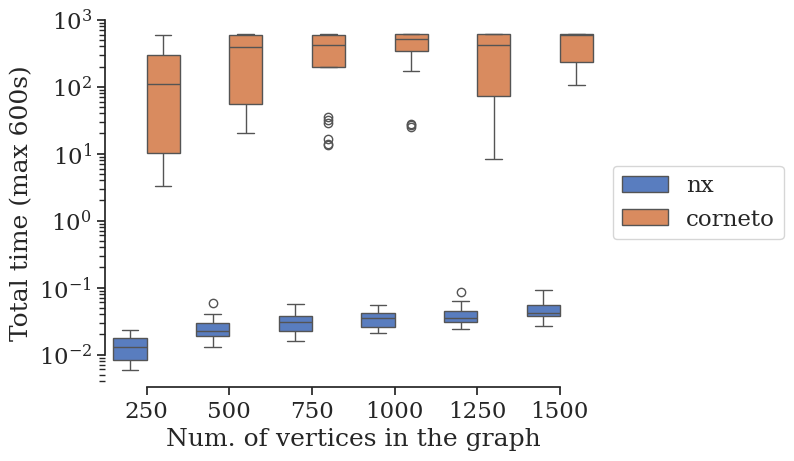

In [13]:
sns.boxplot(data=df, x="graph_nodes", y="time", hue="method", log_scale=True)
sns.despine(trim=True, left=False)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Num. of vertices in the graph")
plt.ylabel(f"Total time (max {max_time}s)")
plt.savefig("steiner_cn_nx_time_600s.pdf", format="pdf")

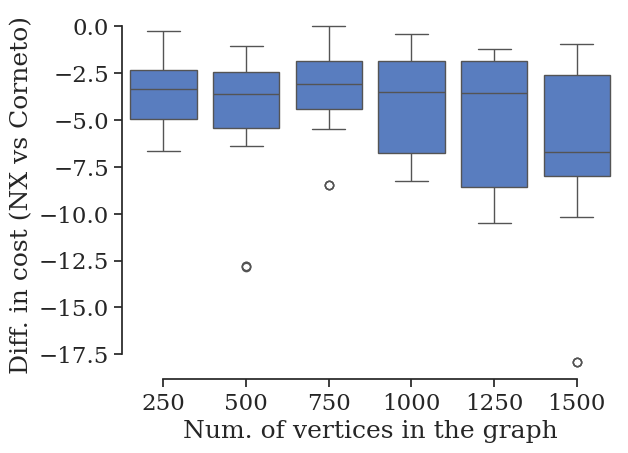

In [14]:
sns.boxplot(data=df[(df.method=="corneto")], x="graph_nodes", y="cost_diff", legend=False)
sns.despine(trim=True, left=False)
plt.xlabel("Num. of vertices in the graph")
plt.ylabel("Diff. in cost (NX vs Corneto)")
plt.savefig("steiner_cn_nx_cost_diff_600s.pdf", format="pdf")

Mean improvement of corneto vs nx: 13.47 %


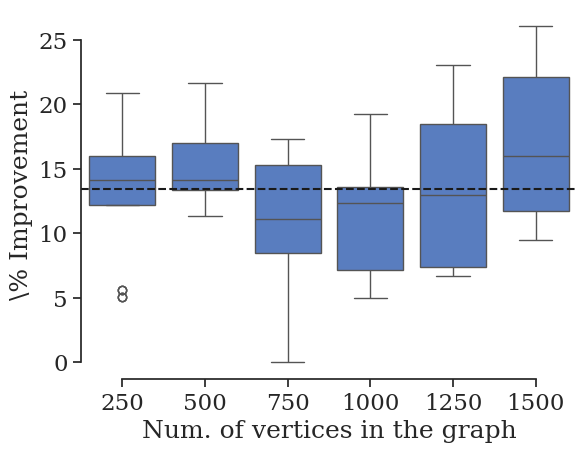

In [15]:
# Average improvement
df_cn = df[df.method=="corneto"].copy()
df_cn["cost_of_nx"] = df_cn["cost_of_steiner_tree"] + df_cn["cost_diff"].abs()
df_cn["improvement"] = ((df_cn["cost_of_nx"] - df_cn["cost_of_steiner_tree"])/df_cn["cost_of_nx"])*100
print(f"Mean improvement of corneto vs nx: {(df_cn['improvement'].mean()):.2f} %")

sns.boxplot(data=df_cn, x="graph_nodes", y="improvement", legend=False)
sns.despine(trim=True, left=False)
plt.xlabel("Num. of vertices in the graph")
plt.ylabel("\% Improvement")
plt.axhline(y=df_cn['improvement'].mean(), linestyle="--", color="k")
plt.savefig("steiner_cost_improv_600s.pdf", format="pdf")

Text(0.5, 0, 'Difference in cost (NX vs CORNETO)')

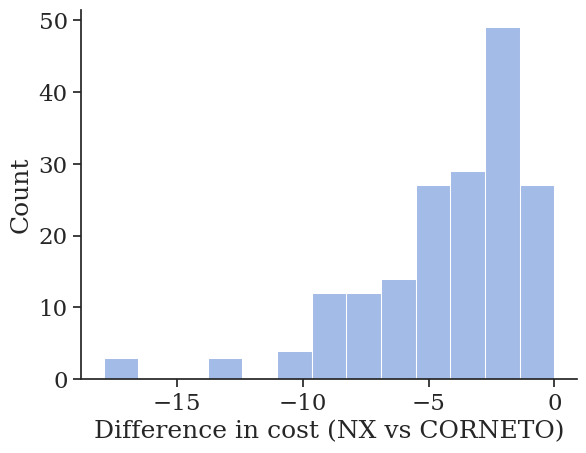

In [16]:
sns.histplot(df[df.method=="corneto"][["cost_diff"]], linewidth=.75, legend=False)
sns.despine(trim=False, left=False)
plt.xlabel("Difference in cost (NX vs CORNETO)")